In [1]:
import numpy as np
import scipy as sp
import sklearn
import sklearn.linear_model
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
np.random.seed(42)
torch.manual_seed(42);

In [3]:
# to zoom in the plot
#%matplotlib widget 

# Inverse dynamical model of a mechanical system

## Dataset

We consider the dataset available here: https://www.nonlinearbenchmark.org/benchmarks/emps. 

The test device is a single prismatic joint, which is modeled as a 1-DoF mechanical system of mass $M$. We apply a force $\tau(t)$ (N) and measure the joint position $q(t)$ (m). 
The applied force is actually measured up to an unknown constant bias $b$ (N). Moreover, friction forces $\tau_{f}(t)$ act on the system.

Newton's law suggests:
$$ M \ddot q(t) = \tau(t) - \tau_{f}(t) - b$$ 


In this notebook, we illustrate the inverse dynamical modeling of the system, namely the problem of reconstructiong $\tau(t)$ from $q(t)$ and (its derivatives). 

The original dataset contains measurements of $q(t)$ and $\tau(t)$ and is already split in a train and a test part. A few pre-processing steps have been performed in the notebook dataset_preproc.ipynb.
For instance, $\dot q(t)$ and $\ddot q(t)$ have been obtained through a careful numerical differentiation of $q(t)$. 

Let us first explore the data!

In [4]:
# Load data
data = sp.io.loadmat('EMPS.mat')
train_tau = data['train_tau'] # force (N)
train_q = data['train_q'] # position (m)
train_dq = data['train_dq'] # velocity (m/s)
train_ddq = data['train_ddq'] # train acceleration (m/s^2)
test_tau = data['test_tau']
test_q = data['test_q']
test_dq = data['test_dq']
test_ddq = data['test_ddq']
ts = data['ts'][0, 0]

In [5]:
train_t = np.arange(0, len(train_q)) * ts
test_t = np.arange(0, len(test_q)) * ts
train_t.shape, test_t.shape

((24841,), (24841,))

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/570403681.py:8: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('train $\dot q$')
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/570403681.py:11: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_title('train $\ddot q$')


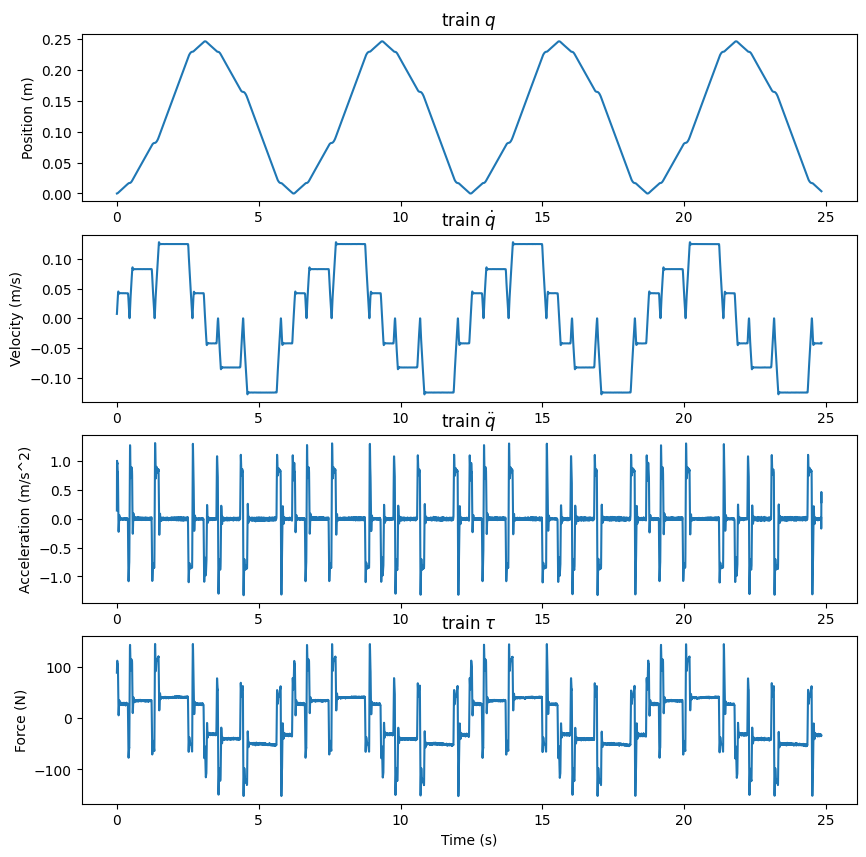

In [6]:
# Visualize data

fig, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].plot(train_t, train_q)
ax[0].set_title('train $q$')
ax[0].set_ylabel('Position (m)')
ax[1].plot(train_t, train_dq)
ax[1].set_title('train $\dot q$')
ax[1].set_ylabel('Velocity (m/s)')
ax[2].plot(train_t, train_ddq)
ax[2].set_title('train $\ddot q$')
ax[2].set_ylabel('Acceleration (m/s^2)')
ax[3].plot(train_t, train_tau)
ax[3].set_title(r'train $\tau$')
ax[3].set_ylabel('Force (N)')
ax[3].set_xlabel('Time (s)');

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/2627655565.py:6: SyntaxWarning: invalid escape sequence '\d'
  ax[1].set_title('test $\dot q$')
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/2627655565.py:9: SyntaxWarning: invalid escape sequence '\d'
  ax[2].set_title('test $\ddot q$')


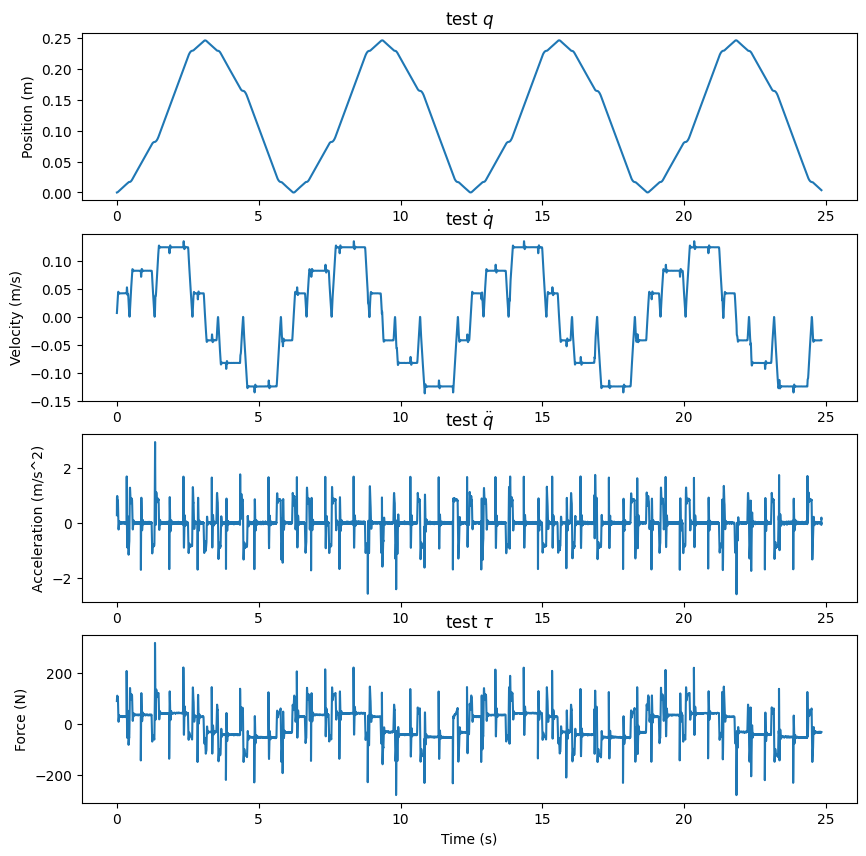

In [7]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10))
ax[0].plot(test_t, test_q)
ax[0].set_title('test $q$')
ax[0].set_ylabel('Position (m)')
ax[1].plot(test_t, test_dq)
ax[1].set_title('test $\dot q$')
ax[1].set_ylabel('Velocity (m/s)')
ax[2].plot(test_t, test_ddq)
ax[2].set_title('test $\ddot q$')
ax[2].set_ylabel('Acceleration (m/s^2)')
ax[3].plot(test_t, test_tau)
ax[3].set_title(r'test $\tau$')
ax[3].set_ylabel('Force (N)')
ax[3].set_xlabel('Time (s)');

## Linear least-squares IDM

A very simple inverse dynamic model (IDM) for this system is:

$$\tau(t) = M\ddot q(t) + F_v \dot q(t) + b$$

which assumes a friction model:
$$ \tau_{f} = -F_v \dot q(t)$$

The free parameters are:
* $M$: system mass
* $F_v$: viscous friction
* $b$: an additional constant, which takes into accound a bias in the measurement setup


The IDM can be written as a standard linear model:

$$ \tau(t) = \phi(t) \theta, \qquad \phi(t) = [\ddot q(t)\, \dot q(t)\, 1], \qquad \theta = [M\, F_v\,  b]^\top$$

The parameters $\theta$ can be fitted with standard least squares.

In [8]:
# Linear Least squares fitting

train_X = np.c_[train_ddq, train_dq] #, np.ones_like(train_q)]
test_X = np.c_[test_ddq, test_dq] #, np.ones_like(test_q)]

train_y = train_tau
test_y = test_tau

lin = sklearn.linear_model.LinearRegression().fit(train_X, train_y)
lin.coef_, lin.intercept_

(array([[ 95.21081826, 411.17660911]]), array([-3.11804161]))

In [9]:
# Model evaluation

train_y_hat = lin.predict(train_X)
train_rmse = np.sqrt(np.mean((train_y - train_y_hat)**2))
test_y_hat = lin.predict(test_X)
test_rmse = np.sqrt(np.mean((test_y - test_y_hat)**2))
train_rmse, test_rmse

(np.float64(9.283652602915705), np.float64(11.211409559706391))

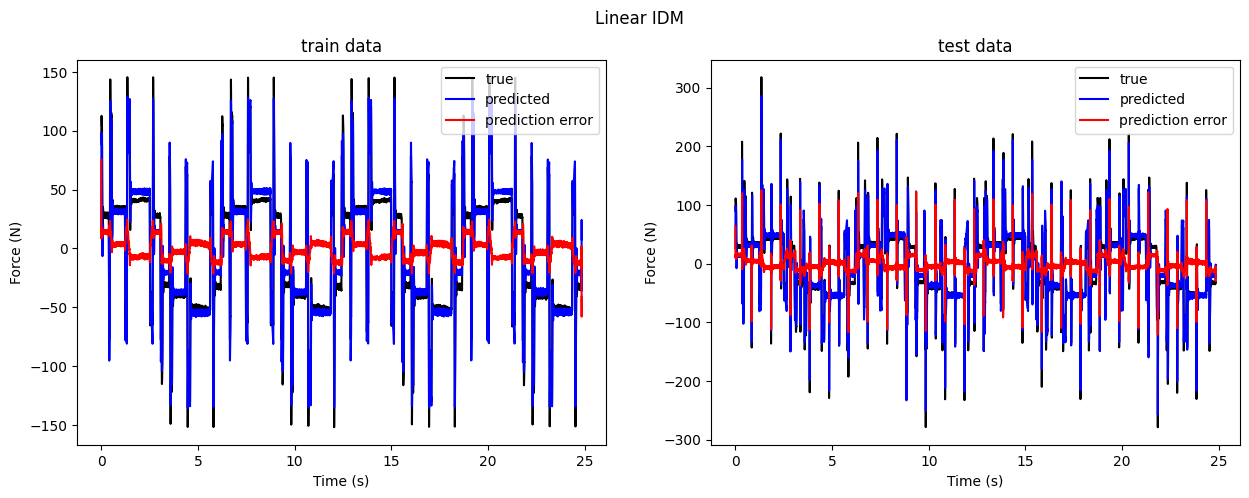

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Linear IDM')
ax[0].plot(train_t, train_y, "k", label='true')
ax[0].plot(train_t, train_y_hat, "b", label='predicted')
ax[0].plot(train_t, train_y - train_y_hat, "r", label='prediction error')
ax[0].legend(loc="upper right")
ax[0].set_title('train data')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Force (N)')

ax[1].plot(test_t, test_y, "k", label='true')
ax[1].plot(test_t, test_y_hat, "b", label='predicted')
ax[1].plot(test_t, test_y - test_y_hat, "r", label='prediction error')
ax[1].legend(loc="upper right")
ax[1].set_title('test data')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Force (N)');

Same in PyTorch (useful only for educational purpose)

In [11]:
# Trining data as pytorch tensors
train_X_torch = torch.tensor(np.c_[train_ddq, train_dq]).float()
train_y_torch = torch.tensor(train_tau).float()

In [12]:
# Linear model in pytorch
friction_lin = nn.Linear(2, 1, bias=True)
friction_lin.weight.data, friction_lin.bias.data

(tensor([[0.5406, 0.5869]]), tensor([-0.1657]))

In [13]:
iters = 100_000
batch_size = 64
lr = 1e-2

In [14]:
# Train the model

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(friction_lin.parameters(), lr=lr)

LOSS = []
for iter in (pbar := tqdm(range(iters))):
    optimizer.zero_grad()
    batch_idx = np.random.randint(0, len(train_X_torch), batch_size)
    preds = friction_lin(train_X_torch[batch_idx])
    loss = criterion(preds, train_y_torch[batch_idx])
    loss.backward()
    optimizer.step()
    LOSS.append(loss.item())
    if iter % 10000 == 0:
        pbar.set_postfix({'loss': loss.item()})


100%|██████████| 100000/100000 [00:10<00:00, 9690.94it/s, loss=76.8] 


In [15]:
friction_lin.weight.data, friction_lin.bias.data # more or less the same as linear least squares

(tensor([[ 95.3627, 411.3774]]), tensor([-3.1387]))

## Linear least-squares IDM with static friction


The linear prediction is not too bad, but it looks somewhat *biased*. Actually, the previous IDM model misses **static friction**, which is relevant in this dataset.

Let us enrich the friction model to:
$$ \tau_{f}(t) = -F_v \dot q(t) - F_c \text{sign}(\dot q(t))$$

We then have:
$$ \tau(t) = M\ddot q(t) + F_v \dot q(t) + F_c \text{sign}(\dot q(t)) + b$$

The IDM with static friction can be modified to:

$$ \tau(t) = \phi(t) \theta, \qquad \phi(t) = [\ddot q(t)\, \dot q(t)\, \text{sign}(q(t))\, 1], \qquad \theta = [M\, F_v\, F_c\, b]^\top,$$

which can still be treated as a linear regression adding the feature $\text{sign}(q(t))$. In machine-learning terms, we are doing *feature engineering*.

In [16]:
train_X_feat = np.c_[train_ddq, train_dq, np.sign(train_dq)]
test_X_feat = np.c_[test_ddq, test_dq, np.sign(train_dq)]

In [17]:
lin_feat = sklearn.linear_model.LinearRegression().fit(train_X_feat, train_y)
lin_feat.coef_, lin_feat.intercept_

(array([[ 95.07423149, 204.29921873,  20.32136663]]), array([-3.17102298]))

In [18]:
train_y_hat = lin_feat.predict(train_X_feat)
train_rmse = np.sqrt(np.mean((train_y - train_y_hat)**2))
#test_y_hat = test_X @ theta_ls
test_y_hat = lin_feat.predict(test_X_feat)
test_rmse = np.sqrt(np.mean((test_y - test_y_hat)**2))
train_rmse, test_rmse

(np.float64(2.4941156049713245), np.float64(6.5061401301669415))

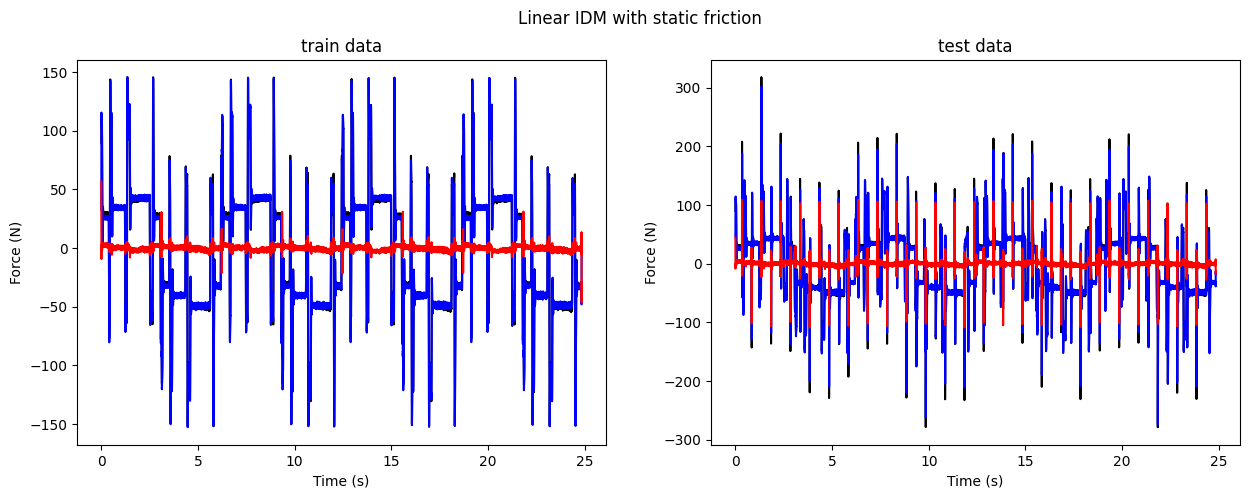

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle('Linear IDM with static friction')
ax[0].plot(train_t, train_y, "k", label='true')
ax[0].plot(train_t, train_y_hat, "b", label='predicted')
ax[0].plot(train_t, train_y - train_y_hat, "r", label='prediction error')
ax[0].set_title('train data')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Force (N)')

ax[1].plot(test_t, test_y, "k", label='true')
ax[1].plot(test_t, test_y_hat, "b", label='predicted')
ax[1].plot(test_t, test_y - test_y_hat, "r", label='prediction error')
ax[1].set_title('test data')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Force (N)');

Train and test performance significantly improved, force estimation qualitatively much better! However, it requires some knowldege.
What if we didn't know about static friction? What if the previous model is still not enough?

# Feed-forward neural network IDM

What if we didn't know about static friction? What if the true torque model is even more complex?

We may fit a neural-netwok IDM!

$$ \tau(t) = \mathrm{FF}(\ddot q, \dot q) $$


In [20]:
train_X_torch = np.c_[train_ddq, train_dq] #, np.sign(train_dq), train_q]
test_X_net = np.c_[test_ddq, test_dq] #, np.sign(test_dq), train_q]

In [21]:
in_dim = train_X_torch.shape[1] # 2
out_dim = 1
batch_size = 128
hidden_size = 32
lr = 5e-4 

ff_net = torch.nn.Sequential(
    torch.nn.Linear(in_dim, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, hidden_size),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_size, 1)
)

dl = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(train_X_torch, dtype=torch.float32),
                                   torch.tensor(train_y, dtype=torch.float32)),
    batch_size=batch_size,
    shuffle=True
)

opt = torch.optim.Adam(ff_net.parameters(), lr=lr)
epochs = 200

LOSS = []
for _ in (pbar := tqdm(range(epochs))):
    for X_batch, y_batch in dl:
        opt.zero_grad()
        y_hat = ff_net(X_batch)
        loss = torch.nn.functional.mse_loss(y_hat, y_batch)
        LOSS.append(loss.item())

        loss.backward()
        opt.step()
    pbar.set_postfix({'loss': loss.item()})



100%|██████████| 200/200 [00:21<00:00,  9.43it/s, loss=52.2] 


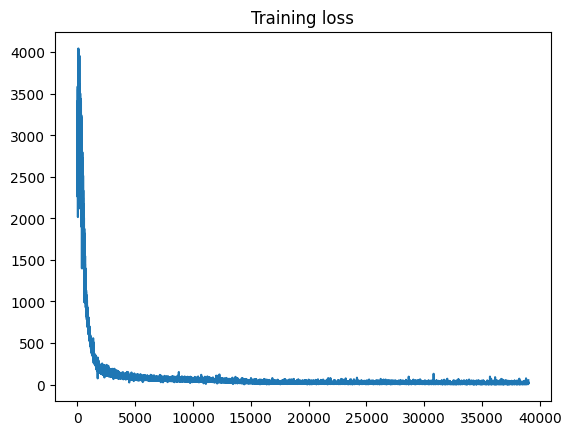

In [22]:
plt.figure()
plt.title("Training loss")
plt.plot(LOSS);

In [23]:
train_y_hat_net = ff_net(torch.tensor(train_X_torch, dtype=torch.float32)).detach().numpy()
test_y_hat_net = ff_net(torch.tensor(test_X_net, dtype=torch.float32)).detach().numpy()

In [24]:
train_rmse_net = np.sqrt(np.mean((train_y - train_y_hat_net)**2))
test_rmse_net = np.sqrt(np.mean((test_y - test_y_hat_net)**2))
train_rmse_net, test_rmse_net

(np.float64(3.651622793427776), np.float64(7.430717683103742))

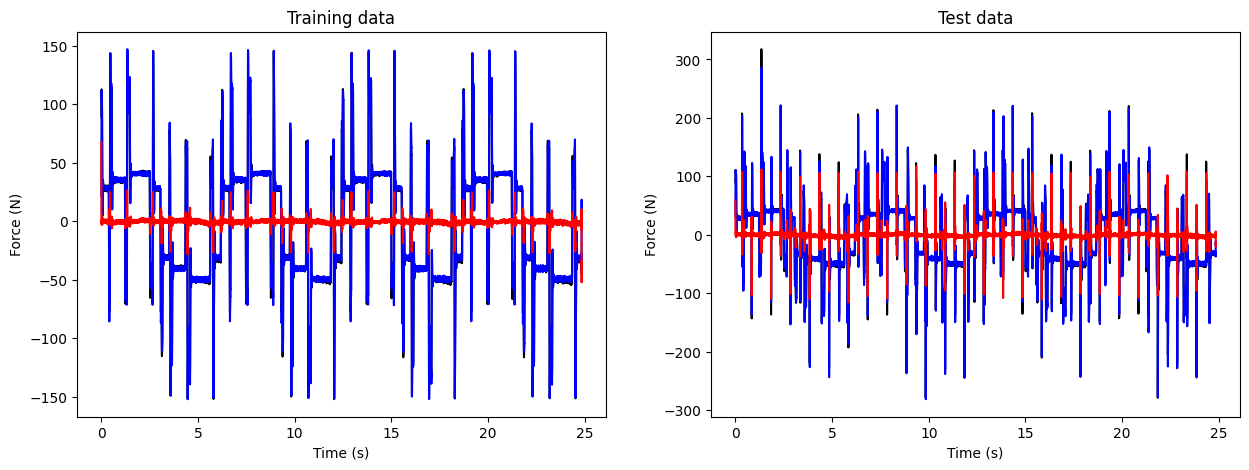

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("Training data")
ax[0].plot(train_t, train_y, "k", label='true')
ax[0].plot(train_t, train_y_hat_net, "b", label='predicted')
ax[0].plot(train_t, train_y - train_y_hat_net, "r", label='prediction error')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Force (N)')

ax[1].set_title("Test data")
ax[1].plot(test_t, test_y, "k", label='true')
ax[1].plot(test_t, test_y_hat_net, "b", label='predicted')
ax[1].plot(test_t, test_y - test_y_hat_net, "r", label='prediction error')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Force (N)');


* The linear model requires an explicit regressor $\text{sign}(\dot q)$ to capture the static friction effect
* The neural network can learn this non-linear effect effect without additional hints
    * But if you provide hints, it might help!  
* On the other hand, the linear model has interpretable parameters, while the net is rather ''black-box''

In this simple case, we can still inspect the neural network graphically, as it is just a function $\mathbb{R}^2 \rightarrow \mathbb{R}$

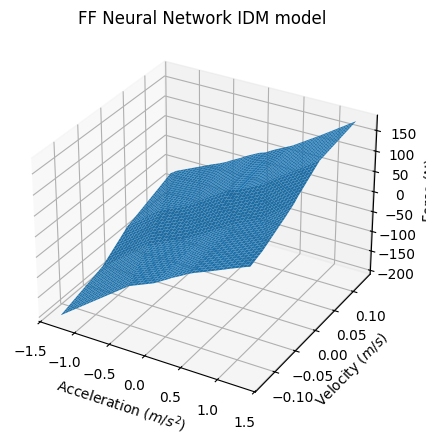

In [26]:
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of values
ddq_range = np.linspace(train_X_torch[:, 0].min(), train_X_torch[:, 0].max(), 500)
dq_range = np.linspace(train_X_torch[:, 1].min(), train_X_torch[:, 1].max(), 500)
DDQ, DQ = np.meshgrid(ddq_range, dq_range)
grid = np.c_[DDQ.ravel(), DQ.ravel()]
grid_feat = np.c_[DDQ.ravel(), DQ.ravel(), np.sign(DQ.ravel())]

# Predict using the neural network
F_net = ff_net(torch.tensor(grid, dtype=torch.float32)).detach().numpy().reshape(DDQ.shape)
F_lin = lin.predict(grid).reshape(DDQ.shape)
F_lin_feat = lin_feat.predict(grid_feat).reshape(DDQ.shape)

# Plot the 3D surface
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(DDQ, DQ, F_net, alpha=1.0)#, cmap='viridis')
#ax.plot_surface(X, Y, F_lin, alpha=0.5)#, cmap='viridis')
#ax.plot_surface(X, Y, Z_net - Z_lin, color="red", alpha=0.5)#, cmap='viridis')

ax.set_xlabel('Acceleration $(m/s^2)$')
ax.set_ylabel('Velocity $(m/s)$')
ax.set_zlabel('Force (N)')
ax.set_title('FF Neural Network IDM model');
#plt.tight_layout()

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:7: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/4062346888.py:4: SyntaxWarning: invalid escape sequence '\d'
  plt.title(f"Force vs $\dot q$  for $\ddot q$={ddq_val:.2f}")
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/4062346888.py:5: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(dq_range, F_net[:, ddq_idx], "k", label="$F = NN(\dot q, \ddot q)$")
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/4062346888.py:6: SyntaxWarning: invalid 

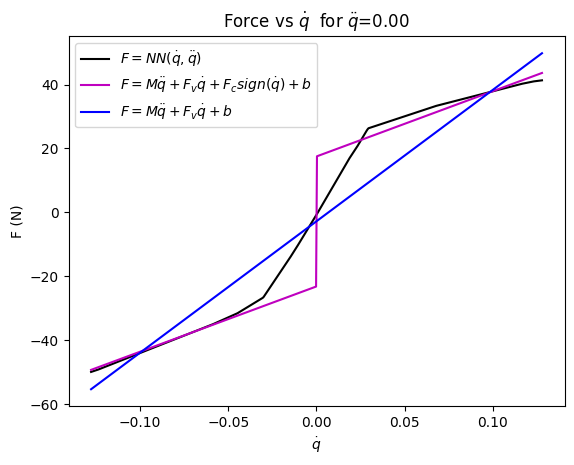

In [27]:
ddq_idx = ddq_range.searchsorted(0.0) # index s.t. ddq_val = 0
ddq_val = ddq_range[ddq_idx]
plt.figure()
plt.title(f"Force vs $\dot q$  for $\ddot q$={ddq_val:.2f}")
plt.plot(dq_range, F_net[:, ddq_idx], "k", label="$F = NN(\dot q, \ddot q)$")
plt.plot(dq_range, F_lin_feat[:, ddq_idx], "m", label="$F = M \ddot q + F_v \dot q + F_c {sign}(\dot q) + b$")
plt.plot(dq_range, F_lin[:, ddq_idx], "b", label="$F = M \ddot q + F_v \dot q + b$")
plt.legend()
plt.xlabel('$\dot q$')
plt.ylabel('F (N)');

* The neural network and the linear IDM model with static friction are pretty close to each other
* The IDM model without static friction cannot capture the curve
* Out of the training region, the neural-network IDM model might be unreliable!

## Physics-inspired neural network

What if we trust Newton, but we want some flexibility for / we are ignorant about friction? We can design a custom grey-box model!

$$\tau(t) = M \ddot q + \mathrm{FF}(\dot q)$$

Linear in $\ddot q$, non-linear in $\dot q$

In [28]:
class CustomIDM(nn.Module):
    def __init__(self, n_q=1, hidden_size=32):
        self.n_q = n_q
        super(CustomIDM, self).__init__()
        self.inertia_net = nn.Linear(n_q, n_q, bias=False)
        self.friction_net = nn.Sequential(
            nn.Linear(n_q, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        inertia = self.inertia_net(x[:, :self.n_q])  # Linear in \ddot q
        friction = self.friction_net(x[:, self.n_q:])  # Non-linear in \dot q
        return inertia + friction


# Example usage
custom_net = CustomIDM(n_q = 1)
opt = torch.optim.Adam(custom_net.parameters(), lr=1e-2)

LOSS = []
for _ in (pbar := tqdm(range(epochs))):
    for X_batch, y_batch in dl:
        opt.zero_grad()
        y_hat = custom_net(X_batch)
        loss = torch.nn.functional.mse_loss(y_hat, y_batch)
        LOSS.append(loss.item())

        loss.backward()
        opt.step()
    pbar.set_postfix({'loss': loss.item()})

100%|██████████| 200/200 [00:24<00:00,  8.21it/s, loss=1.28]  


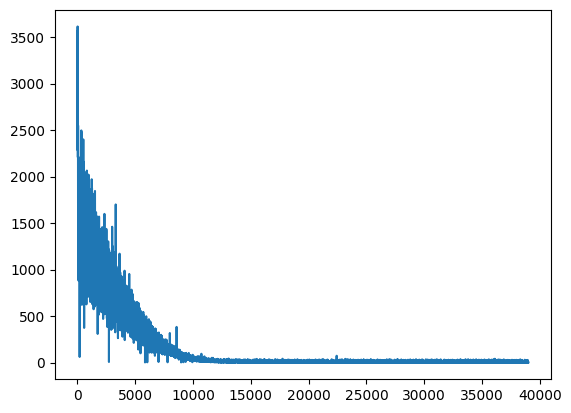

In [29]:
plt.figure()
plt.plot(LOSS)

In [30]:
train_y_hat_net = custom_net(torch.tensor(train_X_torch, dtype=torch.float32)).detach().numpy()
test_y_hat_net = custom_net(torch.tensor(test_X_net, dtype=torch.float32)).detach().numpy()

In [31]:
train_rmse_net = np.sqrt(np.mean((train_y - train_y_hat_net)**2))
test_rmse_net = np.sqrt(np.mean((test_y - test_y_hat_net)**2))
train_rmse_net, test_rmse_net

(np.float64(2.3947820736549437), np.float64(6.485661706207265))

In [32]:
custom_net.inertia_net.weight # that's still a mass!

Parameter containing:
tensor([[95.1400]], requires_grad=True)

<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/2646961190.py:14: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(dq_range, friction_term, label="FF($\dot q$)")
/var/folders/w7/h67z1rn941j1p0m51k08d9xc0000gp/T/ipykernel_17939/2646961190.py:15: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('Velocity $\dot q$')


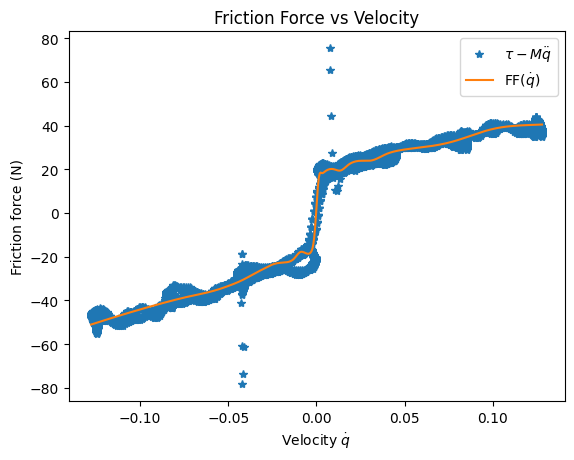

In [33]:
# measured force - predicted inertia force
friction_residual = train_tau - custom_net.inertia_net(torch.tensor(train_ddq, dtype=torch.float32)).detach().numpy()

# Create a grid of values for dq
dq_range = np.linspace(train_X_torch[:, 1].min(), train_X_torch[:, 1].max(), 500)[..., None]

# Extract the friction term from the custom_net
with torch.no_grad():
    friction_term = custom_net.friction_net(torch.tensor(dq_range, dtype=torch.float32)).numpy()

# Plot the friction term
fig = plt.figure()#figsize=(10, 7))
plt.plot(train_dq, friction_residual, "*", label=r"$\tau - M \ddot q$")
plt.plot(dq_range, friction_term, label="FF($\dot q$)")
plt.xlabel('Velocity $\dot q$')
plt.ylabel('Friction force (N)')
plt.title('Friction Force vs Velocity')
plt.legend()
plt.show()